In [ ]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
import glob
import pickle

%matplotlib inline

In [ ]:
# Define a set of object points
objp = np.zeros((6*9, 3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Define arrays to store object (3D space) and image (2D space) points from imported images
objpoints = []
imgpoints = []

# print a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Iterate through the list, searching for chesseboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Use cv2 to find chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    
    if ret == True:
        print('working on ', fname)
        objpoints.append(objp)
        imgpoints.append(corners)
        
        # Draw the found corners, save images to the output_images folder
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        write_name = 'corners_found' + str(idx) + '.jpg'
        cv2.imwrite('./output_images/chessboard_images/' + write_name, img)
        
# Load image for reference
img = cv2.imread('./camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Perform camera calibration for the given object and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

# Save the calibration file
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump(dist_pickle, open("./camera_cal/calibration_pickle.p", "wb"))

In [ ]:
# Read in the saved camera matrix and distortion coefficients

dist_pickle = pickle.load(open("camera_cal/calibration_pickle.p", "rb"))
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

# Read in a test image
img = cv2.imread('./camera_cal/calibration3.jpg')

# Define chessboard size parameters, nx (number of inside corners in x) and ny (number of inside corners in y)

nx = 9
ny = 6

def corners_unwarp(img, nx, ny, mtx, dist):
    
    # Undistort using mtx and dist
    img_size = (img.shape[1], img.shape[0])
    
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    # Convert image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
    
    # Darw corners if corners are found
    if ret == True:
        img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        
        # Define 4 source points src = np.float32([[,],[,],[,],[,]])
        # Detected corners found using the automatic corner detection
        offset = 100
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
            
        # Define 4 destination points dst = np.float32([[,],[,],[,],[,]])
        dst = np.float32([[offset, offset],[img_size[0]-offset, offset],[img_size[0]-offset, img_size[1]-offset],[offset, img_size[1]-offset]])
            
        # Use cv2.getPerspectiveTransform() to get M, the transform matrix
        M = cv2.getPerspectiveTransform(src, dst)
            
        # Use cv2.warpPerspective() to warp your image to a top-down view
        warped = cv2.warpPerspective(undist, M, img_size)
    
    return warped, M

In [ ]:
# Define a stand-alone function to perform the top-down perspective warp

def perspective_transform(image):

    img_size = (image.shape[1], image.shape[0])

    preprocessImage = np.zeros_like(img[:,:,0])

    bot_width = 0.75 # percent of bottom trapizoid height
    mid_width = 0.08 # percent of middle trapizoid height
    height_pct = 0.62 # percent for trapizoid width
    bottom_trim = 0.95 # percent from top to bottom to avoid car hood

    src = np.float32([[img.shape[1] * (0.5 - mid_width / 2), img.shape[0] * height_pct],
                      [img.shape[1] * (0.5 + mid_width / 2), img.shape[0] * height_pct],
                      [img.shape[1] * (0.5 + bot_width / 2), img.shape[0] * bottom_trim],
                      [img.shape[1] * (0.5 - bot_width / 2), img.shape[0] * bottom_trim]])

    offset = img_size[0] * 0.25

    dst = np.float32([[offset, 0], [img_size[0]-offset, 0], [img_size[0]-offset, img_size[1]], [offset, img_size[1]]])
    
    # Define topdown perspective transform

    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    warped = cv2.warpPerspective(image, M, img_size, flags = cv2.INTER_LINEAR)

    return warped

### Finding Lines

In [20]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

def lane_line(binary_warped):
    
    # Input is binary_warped image,
    # highest proportaion of white vs black will be the lane lines
    # A histogram is produced for the bottom part of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped)) * 255
    
    # Find peak historgram levels of the left and right sides of the histogram data
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Define the number of sliding windows to search with
    nwindows = 9
    
    # Define sliding window height
    window_height = np.int(binary_warped.shape[0]//nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Set the width of the windows +/- margin
    margin = 100
    
    # Set minimum number of pixels found to recenter window
    minpix = 50
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1) * window_height
        win_y_high = binary_warped.shape[0] - window * window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices to the left and right lane lists
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each pixel set
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Fit a second order polynomial to each
    left_fit_m = np.polyfit(lefty * ym_per_pix, leftx * xm_per_pix, 2)
    right_fit_m = np.polyfit(righty * ym_per_pix, rightx * xm_per_pix, 2)
    
    return(left_fit, right_fit, left_fit_m, right_fit_m, left_lane_inds, right_lane_inds, out_img, nonzerox, nonzeroy)

In [22]:
#################################
### Visualization of lane finding
#################################
    
def lane_find_vis(image, ax):
    
    left_fit, right_fit, left_fit_m, right_fit_m, left_lane_inds, right_lane_inds, out_img, nonzerox, nonzeroy = lane_line(image)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0] * ploty**2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty**2 + right_fit[1] * ploty + right_fit[2]

    # Generate colors for left and right lanes
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    ax.imshow(out_img)
    ax.plot(left_fitx, ploty, color='yellow')
    ax.plot(right_fitx, ploty, color='yellow')
    return ( left_fit, right_fit, left_fit_m, right_fit_m )

def lane_overlay(image):
    
    left_fit, right_fit, left_fit_m, right_fit_m = lane_find_vis(image, ax)
    
    ax.set_title(imagePathName)
    ax.axis('off')
    
    return 

In [23]:
# Read in a thresholded image
warped = mpimg.imread('./examples/warped_example.jpg')

lane_line(warped)

plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

NameError: name 'out_img' is not defined

In [ ]:
####################################################
### Derive radius of curvature from the polynomials
####################################################
    
# Compute convsions between pixels and real-world dimensions
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty * ym_per_pix, left_fitx * xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty * ym_per_pix, right_fitx * xm_per_pix, 2)

# Calculate the new radii of curvature
left_curverad =  ((1 + (2 * left_fit_cr[0] * y_eval * ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2 * left_fit_cr[0])
right_curverad = ((1 + (2 * right_fit_cr[0] * y_eval * ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2 * right_fit_cr[0])

# Compute car position
m_car = binary_warped.shape[1] / 2
m_lane = (left_fitx[0] + right_fitx[0]) / 2
offset_right_from_center_m = (m_lane - m_car) * xm_per_pix

# Compute radius of curvature in meters
avg_radius_meters = np.mean([left_curverad, right_curverad])

In [ ]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!

nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

margin = 100

left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
left_fit[1]*nonzeroy + left_fit[2] + margin))) 

right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

In [ ]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped)) * 255
window_img = np.zeros_like(out_img)

# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [ ]:
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0] - 1, binary_warped.shape[0])

left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

### Centroid Sliding Window Search

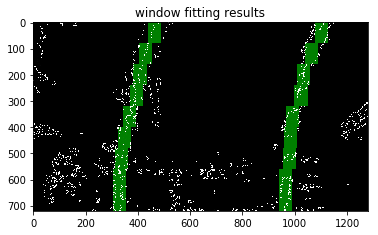

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import cv2

# Read in a thresholded image
warped = mpimg.imread('./examples/warped_example.jpg')

# window settings
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(image[int(3*image.shape[0]/4):,:int(image.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(image[int(3*image.shape[0]/4):,int(image.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(image.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(image.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,image.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,image.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids

window_centroids = find_window_centroids(warped, window_width, window_height, margin)

# If we found any window centers
if len(window_centroids) > 0:

    # Points used to draw all the left and right windows
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)

    # Go through each level and draw the windows 	
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
        l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
        r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
        # Add graphic points from window mask here to total pixels found 
        l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
        r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # Draw the results
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channel
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
    warpage= np.dstack((warped, warped, warped))*255 # making the original road pixels 3 color channels
    output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
 
# If no window centers found, just display orginal road image
else:
    output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

# Display the final results
plt.imshow(output)
plt.title('window fitting results')
plt.show()
